# Лабораторная работа№1

**Цель работы:** изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

**Задачи лабораторной работы:**

1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования.
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from scipy.fftpack import fft
from scipy.io.wavfile import read, write
from scipy import signal

%matplotlib inline

In [171]:
def show_plt():
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title('03-01-05-01-01-02-12_A12.wav')
    plt.show()

**2. Постоение огибающей:**

Выполним загрузку аудио сигнала:

In [172]:
samplerate, data = read('03-01-05-01-01-02-12_A12.wav')
ipd.Audio('./03-01-05-01-01-02-12_A12.wav')

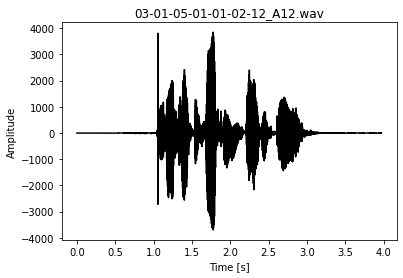

In [173]:
length = data.shape[0] / samplerate
time = np.linspace(0., length, data.shape[0])

plt.plot(time,data, color="black")
show_plt()

Построим огибающую:

Имеется сигнал $ x(i), i = 0,1,...,N - 1$. Хотим построить огибающую $y(j), j = 0,1,...,n - 1$. Пусть $m = [N/n]$ - число точек в интервале усреднения. Тогда
$$y(i) = 1/m * \sum \limits_{k=mj} ^{mj+m-1} |x(k)|$$

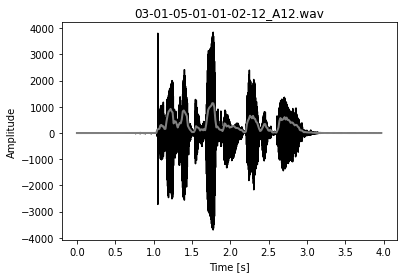

In [174]:
n = 300

m = int(data.shape[0] / n)
curve = np.linspace(0, length, n)
arr = []
# y(j)
for j in range(n):
    sum = 0
    for k in range(m * j, m * j + m):
        sum += abs(data[k])
    arr.append(sum / m)

    
plt.plot(time,data, color="black")
plt.plot(curve, arr, linewidth=2, color="grey")
show_plt()

**3. Фильтрация:**

Выбрать один из 4 основных типов фильтров (ФНЧ, ФВЧ, ПФ, РФ)

Был выбран тип фильтров ФНЧ (фильтр нижних частот)

Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$. Порядок фильтра - $m$. Тогда вычисляем
$$wn = 2*F_{s}/F_{d}$$

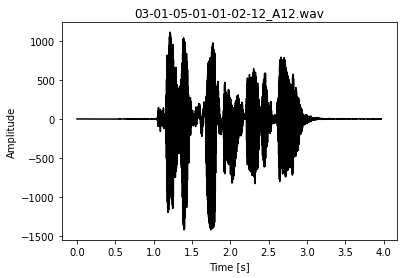

In [176]:
m = 1
F_s = 600 
wn = 2 * F_s / samplerate

_b,_a = signal.butter(m, wn, 'lowpass')
filtedData = signal.filtfilt(_b, _a, data)

plt.plot(time, filtedData, color="black")
show_plt()

In [177]:
filtedData = filtedData.astype(np.int16)
write("FNC.wav", samplerate, filtedData)
ipd.Audio('./FNC.wav')

**3. Амплитудный детектор сигнал/шум:**

Определяем среднее сигнала по амплитуде (без учета знака):
    $$mid = 1/N*\sum \limits_{k=0} ^{N-1}|x(k)|$$

Определяем порог детектора - $Th = \alpha * mid$, где $0 < \alpha < 1$ подбирается экспериментально. Задаем величину "провала"(в отсчетах) - $k$. Обозначим $y(i)$ - сигнал после детектирования.

- **Событие "начало сигнала".** Если $x(i)$ в течении $k$ отсчетов превышает порог, $y(i) = x(i)$.
- **Событие "окончание сигнала".** Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$.

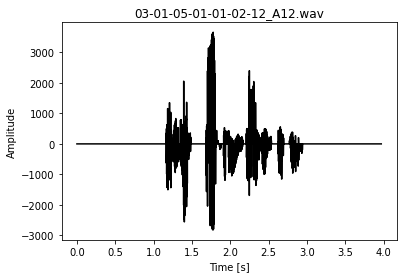

In [178]:
a = 0.5

sum = 0
for k in range(data.shape[0]):
    sum += abs(data[k])    
mid = sum / data.shape[0]

Th = a * mid

y = np.zeros(data.shape[0])

k = 50
above = 0
below = 0
for i in range(data.shape[0]):
    if abs(data[i]) > Th:
        above += 1
        below = 0
        if above >= k:
            y[i] = data[i]
    else:
        below += 1
        above = 0

plt.plot(time, y, color="black")
show_plt()

In [179]:
y = y.astype(np.int16)
write("detector.wav", samplerate, y)
ipd.Audio('./detector.wav')

**4. Эхо (простейший ревербератор)**

- Ревербератор реализован, как набор линий задержки. Число линий задержки $N_{L} >= 8$. Каждая линия задержки имеет свой весовой коэффициент (задается пользователем): 
$$\alpha_{1} > \alpha_{2} > \dots > \alpha_{N_{L}}.$$
-  Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.
- Желаемое соотношение между ”сухим”и обработанным сигналом задается коэффициентом применимости $\gamma$.
- Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка $D_1$, а величины остальных определяются автоматически через нее: 
$$D_i = D_12(1-i)/ N_L, i = 2, \dots,N_L.$$
Для готовой конфигурации пользователь вручную задает последовательность $$D_1> D_2 > \dots > D_{N_L}.$$

In [180]:
gamma = 0.7
N_l = 8
D = [0 for i in range(N_l)]
a = [0 for i in range(N_l)]
D[0] = 10000
a[0] = 1

for i in range(1,N_l):
    D[i] = round(D[i - 1] / 2)
    a[i] = a[i - 1] / 2

fragments = []

for i in range(N_l):
    frag = [0 for i in range(D[i])]
    frag.extend(data)
    fragments.append([frag[j]*a[i] for j in range(len(frag))])

echo = fragments[0]
for i in range(1, N_l):
    for j in range(len(fragments[i])):
        echo[j] += fragments[i][j]

filted_echo = signal.filtfilt(_b,_a, echo)    

for i in range(len(filted_echo)):
    filted_echo[i] *= gamma
    
for i in range(len(data)):
    filted_echo[i] += data[i]

In [181]:
filted_echo = np.array(filted_echo).astype(np.int16)
write("echo.wav",samplerate, filted_echo)
ipd.Audio('./echo.wav')

**5. Классический Distortion (опционально)**

Обозначим входной сигнал и выходной сигналы, соответственно как $x(i)$ и $y(i) i = 0,1,\dots,N - 1$. Пользователь задает **порог** - $Th$ и максимальное значение сигнала $Max > Th$. Тогда 
$$Y(i) = 
 \begin{cases} x(i), |x(i)| <= Th, \\ Max * sign(x(i)), |x(i)| > Th
 \end{cases}$$

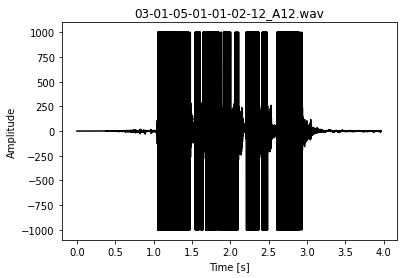

In [182]:
Th = 300
Max = 1000

arr = []
for i in range(len(data)):
    if abs(data[i]) <= Th:
        arr.append(data[i])
    else:
        arr.append(Max * np.sign(data[i]))

plt.plot(time, arr, color="black")
show_plt()  

In [183]:
dist_arr = np.array(arr).astype(np.int16)
write("distortion.wav",samplerate, dist_arr)
ipd.Audio('./distortion.wav')

**Вывод:**

В ходе выполнения лабораторной работы были применены на практике библиотеки языка Python: matplotlib, numpy, scipy, с помощью которых обрабатывались звуковые сигналы. Так же был освоен Jupyter Notebook.